[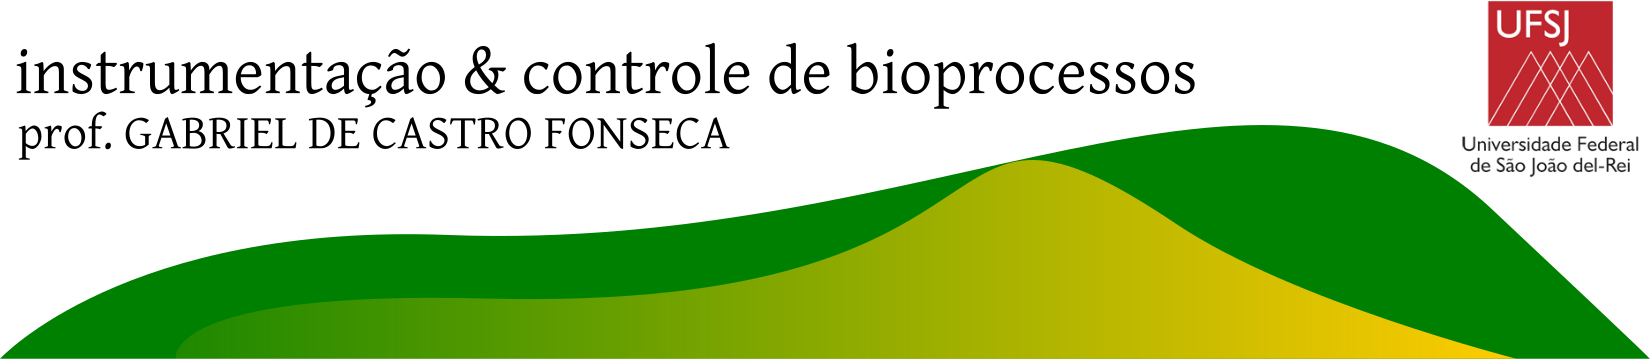](Aulas-Sumário.ipynb)

# Projeto e sintonia de controladores II

*Prof. Gabriel de Castro Fonseca (DQBIO/UFSJ)*<br>
*Instrumentação e Controle de Bioprocessos*

Este documento é publicado sob os termos da licença [GNU General Public Licence 3.0](https://www.gnu.org/licenses/gpl-3.0.en.html).

## Controle de Modelo Interno

O Controle de Modelo Interno (do inglês *Internal Model Control, IMC*) é uma evolução do método da síntese direta que consiste de uma técnica de sintonização que usa um modelo do processo acoplado ao controlador a fim de aperfeiçoar o desempenho do sistema de controle.

O sistema de controle de modelo interno pode ser representado pela figura abaixo, na qual $G(s)$ é a função de transferência real do processo, que pode não ser perfeitamente conhecida; $G^\prime(s)$ é o modelo que representa essa função e $Q(s)$ é a função de transferência do controlador de modelo interno.

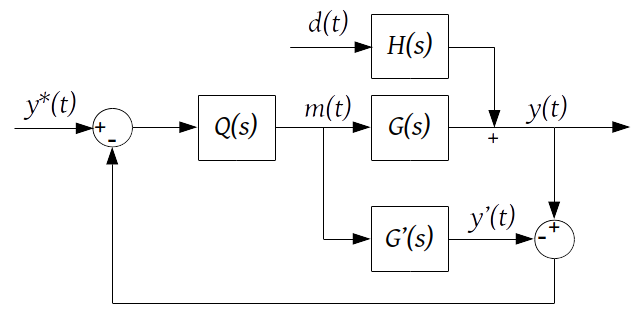

A ideia do controle de modelo interno é sintonizar um controlador que produz uma resposta adequada ao modelo de um processo e, então, compensar o erro do modelo. Se o modelo for perfeito e não houver distúrbios (erro zero), o sistema estará controlado conforme o planejado. Se o modelo for imperfeito ou houver distúrbios, o controle por realimentação atuará no sentido de aproximar o sistema da situação de erro zero.

Observe que a diferença entre a figura mostrada acima e a próxima figura é apenas cosmética: ambas representam igualmente o IMC.

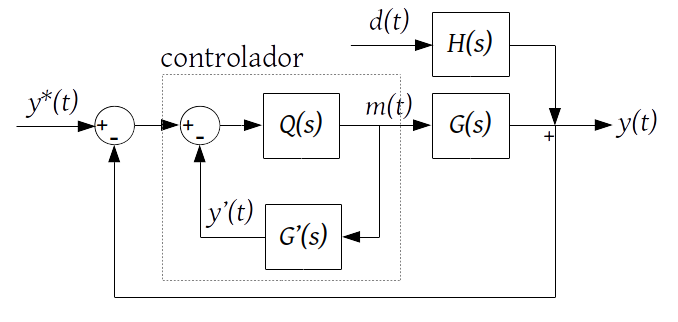

A estrutura IMC pode ser convertida a uma estrutura de realimentação com controle PID como aquela com que estamos acostumados.

O projeto de controladores PID baseados em IMC segue as seguintes etapas:

1. Formule um modelo $G^\prime(s)$ que seja represente o sistema real.

2. Fatore o modelo $G^\prime(s)$ do processo em duas partes: uma parte inversível (a "parte boa") $G^-(s)$ contendo polos e zeros negativos e uma parte não inversível (a "parte má") $G^+(s)$, contendo os polos e zeros positivos e o tempo-morto. Use uma aproximação de Padé caso exista tempo-morto.

3. Encontre o controlador IMC ideal $Q^\prime(s)$ invertendo a "parte boa" do modelo:

$$
    Q^\prime(s) = \frac{1}{G^-(s)}
$$

4. Adicione um filtro $\Phi(s)$ ao controlador IMC ideal.

$$
    Q(s) = \Phi(s) Q^\prime(s)
$$

O filtro geralmente tem a forma:

$$ 
    \Phi(s) = \frac{\gamma s + 1}{(\lambda s + 1)^n}
$$

O valor de $\lambda$, assim como no método da síntese direta, é um parâmetro ajustável. Quanto menor o seu valor, mais rápida a resposta; quanto maior, mais robusta.

O valor de $\gamma$ é escolhido de forma a cancelar algum polo instável ou muito lento no denominador da "parte má" do modelo. Se não houver necessidade disso, $\gamma = 0$.

Geralmente escolhemos $n$ de forma a deixar a fração própria ou semiprópria, ou seja, a ordem do denominador do filtro deve ser menor ou igual à ordem do numerador.

5. Encontre o controlador PI ou PID apropriado usando a fórmula

$$
    C(s) = \frac{Q(s)}{1-G^\prime(s)Q(s)}
$$

A função de transferência encontrada pode ter a forma de um PID ideal ou com filtro:

$$
    C(s) = K_c\left( \frac{\tau_I\tau_D s^2 + \tau_I s + 1}{\tau_Is(\alpha \tau_d s + 1)} \right)
$$


### Exemplo 1: Problema servo, sistema capacitivo com tempo morto

Passo 1: Vamos partir da hipótese de que nosso sistema pode ser representado pela função de transferência $G^\prime (s) = \frac{Ke^{-\theta s}}{\tau s + 1} $.

Passo 2: Vamos aproximar o tempo-morto com Padé de 1ª ordem e separar a "parte boa" da "parte má":

\begin{gather*}
G^\prime(s) \approx  \frac{K}{\tau s + 1} \frac{1-\frac{\theta}{2}s}{1+\frac{\theta}{2}s} \\
G^- = \frac{K}{(\tau s + 1)(\frac{\theta}{2}s+1)} \\
G^+ = -\frac{\theta}{2}s+1
\end{gather*}

Passo 3: O controlador IMC ideal é o inverso da "parte boa".

$$
    Q^\prime (s) = \frac{(\tau s + 1)(\frac{\theta}{2}s+1)} K
$$

Passo 4: A "parte má" do modelo não tem denominador para ser cancelado, logo $\gamma = 0$. Como não há numerador, $n=1$ basta para o filtro.

$$
    \Phi(s) = \frac{1}{\lambda s + 1}
$$

Parte 5: Encontramos o PID resultante fazendo

\begin{gather*}
    C(s) = \frac{ \frac{1}{\lambda s + 1} }{\frac{K}{(\tau s + 1)(\frac{\theta}{2}s+1)} - \frac{K(1-\frac{\theta}{2}s)}{(\tau s + 1)(1+\frac{\theta}{2}s)(\lambda s + 1)} } \\
    C(s) = \frac{(\tau s + 1)(\frac{\theta}{2}s+1)}{K(\lambda  + \frac{\theta}{2})s} \\
    C(s) = \frac{1}{K} \frac{\frac{\theta}{2}\tau s^2 + (\tau +\frac{\theta}{2})+1}{(\lambda + \frac{\theta}{2})s}
\end{gather*}

O resultado é um PID ideal sem filtro.

$$
    \frac{1}{K} \frac{\tau\frac{\theta}{2} s^2 + (\tau +\frac{\theta}{2})s+1}{(\lambda + \frac{\theta}{2})s} = K_c\left( \frac{\tau_I\tau_D s^2 + \tau_I s + 1}{\tau_Is} \right)
$$

Comparando-o à função de transferência do PID podemos encontrar imediatamente o valor de $\tau_I = \tau+\frac{\theta}2$.

A partir daí, segue-se que
$$
    \tau_D = \frac{\tau\frac{\theta}{2}}{\tau + \frac{\theta}{2}}
$$
$$
    K_c = \frac{\tau + \frac{\theta}{2}}{K(\lambda + \frac{\theta}{2})}
$$

Abaixo repetimos o problema da [aula passada](sintonia1.ipynb), com $K=1$ e $\tau=1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.integrate import odeint

In [23]:
def sist_1otm(t,Kc,τi,τd,θ):
    Km = 1
    Kf = 1
    τ  = 1
    K = Km*Kf*Kc
    a = [
            1,
            τ+θ/2 + θ**2/12/τi*K - θ/2*K + τd*K,
            θ**2/12 + τ*θ/2+θ**2/12*K - θ/2*τd*K,
            θ**2/12*(τ + τd*K)
        ]
    def eqdif(y,t,d,sp):
        y,dy,d2y,ie,iea = y #ie: integral do erro, iea: integral do erro absoluto
        e = sp - y 
        ea = abs(sp-y)
        d3y = 1/a[3] * ( K*e*(1 - θ/2/τi) + K*ie/τi - a[2]*d2y - a[1]*dy - a[0]*y )
        return dy, d2y, d3y, e, ea
    y = odeint(eqdif,[0.0]*5,t,args=(0,1))
    iea = y[-1,-1]
    y = y[:,0]
    return y, iea

def principal(θ,λ):
    t = np.linspace(0,100,201)
    # síntese direta
    Kc = 1/(λ+θ)
    τi, τd = 1, 0
    y, iea1 = sist_1otm(t,Kc,τi,τd,θ)
    plt.plot(t,y,label = "Síntese direta (PI)")
    τi = 1+θ/2
    Kc = τi/(λ+θ/2)
    τd = θ/2/τi
    y, iea2 = sist_1otm(t,Kc,τi,τd,θ)
    plt.rcParams["figure.figsize"]=[7,5]
    plt.rcParams.update({'font.size': 14})
    plt.plot(t,y,label = "Controle de modelo interno (PID)")
    plt.xlabel("tempo, $t$")
    plt.ylabel("resposta em malha fechada, $y(t)$")
    plt.legend()
    plt.grid()

θ_widget = widgets.FloatLogSlider(base=10, min=-1, max=1, step=1, value=-1, description = r'$\theta$')
λ_widget = widgets.FloatSlider(min=1, max=15, step=1, value=0, description = r'$\lambda$')
w = widgets.interact(principal,θ = θ_widget, λ = λ_widget)
#w.widget.children[-1].layout.height = '500px'
display(w)

interactive(children=(FloatLogSlider(value=0.1, description='$\\theta$', max=1.0, min=-1.0, step=1.0), FloatSl…

<function __main__.principal(θ, λ)>

Para tempos mortos pequenos não observamos diferença entre a resposta por síntese direta e a resposta usando o controle de modelo interno, mas para valores maiores a vantagem do IMC fica evidente: o tempo morto é compensado e a resposta do problema servo é levada para o valor desejado mais rapidamente.

### Exemplo 2: Problema regulador, sistema instável

Passo 1: Suponha que nosso sistema pode ser modelado pela função de transferência $G^\prime (s) = \frac{K}{-\tau s + 1}$, $\tau > 0$.

Observe que apesar de reslvermos um problema regulador, ainda é a função de transferência $G(s)$ que devemos modelar, e não $H(s)$!

Passo 2: Nosso sistema tem apenas "parte má", logo:
$$
    G^-(s) = 1\;;\qquad G^+(s) = \frac{K}{-\tau s + 1}
$$

Passo 3: O inverso da parte boa é $Q^\prime(s) = 1$

Passo 4: O filtro tem fórmula geral
$$
    \Phi(s) = \frac{\gamma s + 1}{(\lambda s + 1)^n}
$$

Vamos escolher um $\gamma$ que rejeite o polo $s = \frac{1}{\tau}$. Para isso fazemos $\Phi(\frac{1}\tau) = 1$:

\begin{gather*}
    \frac{\gamma \cdot (\frac{1}\tau) + 1 }{(\lambda \cdot (\frac{1}\tau) + 1)^n} = 1 \\
    \frac\gamma\tau + 1 = \left( \frac\lambda\tau + 1 \right)^n
\end{gather*}

Fazendo $n=2$,

\begin{gather*}
    \gamma = \tau\left( \frac{\lambda^2}{\tau^2} + 2\frac\lambda\tau + 1 \right) - 1 \\
    \gamma = \lambda\left(\frac\lambda\tau + 2\right)
\end{gather*}

Como $Q^\prime(s) = 1$, $Q(s) = Q^\prime(s) \Phi(s) = \Phi(s)$.

Passo 5: Encontramos o PID fazendo

\begin{gather*}
    C(s) = \frac{Q(s)}{1-G^\prime(s)Q(s)} \\
    C(s) = \frac{\frac{\gamma s + 1}{(\lambda s + 1)^2}}{1 + \frac{K}{-\tau s + 1}\frac{\gamma s + 1}{(\lambda s + 1)^2}} \\
    \vdots \\
    C(s) = \frac{\gamma}{K(2\lambda - \gamma)}\frac{\gamma s + 1}{\gamma s}
\end{gather*}

Podemos deduzir que $\tau_I = \gamma = \lambda\left(\frac\lambda\tau + 2\right)$ e $K_c = \frac{\gamma}{K(2\lambda - \gamma)} = -\frac{\lambda + 2\tau}{K\lambda}$.

In [49]:
def sist_inst(t,Kc,τi,τd):
    Km = 1
    Kf = 1
    Kd = 1
    τ  = 1
    K = Km*Kf*Kc
    def eqdif(y,t,d,sp):
        y,ie,iea = y #ie: integral do erro, iea: integral do erro absoluto
        e = sp - y 
        ea = abs(sp-y)
        dy = Kd*d + Km*Kf*Kc*(e + (ie/τi if τi != 0 else 0) ) + y 
        return dy, e, ea
    y = odeint(eqdif,[0.0]*3,t,args=(1,0))
    iea = y[-1,-1]
    y = y[:,0]
    return y, iea

def principal(λ):
    t = np.linspace(0,10,201)
    γ = λ*(λ+2)
    Kc = (λ+2)/λ 
    τi, τd = γ, 0
    y, iea = sist_inst(t,Kc,τi,τd)
    plt.rcParams["figure.figsize"]=[12,5]
    plt.rcParams.update({'font.size': 14})
    plt.subplot(1,2,1)
    plt.plot(t,y)
    plt.xlabel("tempo, $t$")
    plt.ylabel("resposta em malha fechada, $y(t)$")
    plt.grid()
    plt.subplot(1,2,2)
    plt.semilogy(t,y,label = "com controle (PI)")
    z, _ = sist_inst(t,0,0,0)
    plt.semilogy(t,z,label = "sem controle")
    plt.xlabel("tempo, $t$")
    plt.ylabel("resposta em malha fechada, $y(t)$")
    plt.legend()
    plt.grid()
    print(f"IEA = {iea:.4f}")

λ_widget = widgets.FloatSlider(min=0.5, max=1, step=.25, value=.25, description = r'$\lambda$')
w = widgets.interact(principal,θ = θ_widget, λ = λ_widget)
#w.widget.children[-1].layout.height = '500px'
display(w)

interactive(children=(FloatSlider(value=0.5, description='$\\lambda$', max=1.0, min=0.5, step=0.25), Output())…

<function __main__.principal(λ)>

## Bibliografia

* B.W. Bequette. (2003). Process Control: Modeling, Design and Simulation. PHI Learning. Capítulos 8 e 9.
* C. Garcia (2017). Controle de Processos Industriais: Estratégias Convencionais. Volume 1, Blucher. Capítulo 8
* C.A. Smith, A. Corripio (2008). Princípios e Prática do Controle Automático de Processo. 3ª ed. LTC. Capítulos 7.